# Setup

You need this to read files from Google Drive


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [61]:
import pandas as pd
import numpy as np
import random
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
pd.options.display.max_rows = 60
pd.options.display.min_rows = None

In [62]:
random.seed(1)
np.random.seed(1)

# Data Preparation

## Training / Test Data
Original Data is from https://github.com/marcoortu/jira-social-repository . This is from the paper "The Jira Repository Dataset" by Marco Ortu et al - see https://www.researchgate.net/publication/301370380_The_JIRA_Repository_Dataset . This was then processed to remove "junk" like email addresses, URLs as described in the notebook ExploratoryDataAnalysis.ipynb and DNNModelAnalysis.ipynb (see section "Increase size of data set")

Steps to prepare the data for BlazingText can be found here: https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html

In [24]:
dataset = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Octopus2/BlazingText/JIRA_OPEN_DATA_LARGESET_PROCESSED.csv")

In [25]:
dataset.head()

Unnamed: 0  ...                                           features
0           0  ...  MAX_VERSIONS not respected. Below is a report ...
1           1  ...  Splitting log in a hostile environment -- bad ...
2           2  ...  DependentColumnFilter.toString() throws NullPo...
3           3  ...  Thrift host and port are hardcoded in thrift  ...
4           4  ...  MapReduce based tests broken on Hadoop  . . -a...

[5 rows x 5 columns]

In [26]:
dataset.dtypes

Unnamed: 0      int64
title          object
description    object
priority       object
features       object
dtype: object

In [27]:
dataset.columns

Index(['Unnamed: 0', 'title', 'description', 'priority', 'features'], dtype='object')

(array([ 2949.,     0., 21272.,     0., 12550.,     0.,   936.,     0.,
         3657.,   149.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

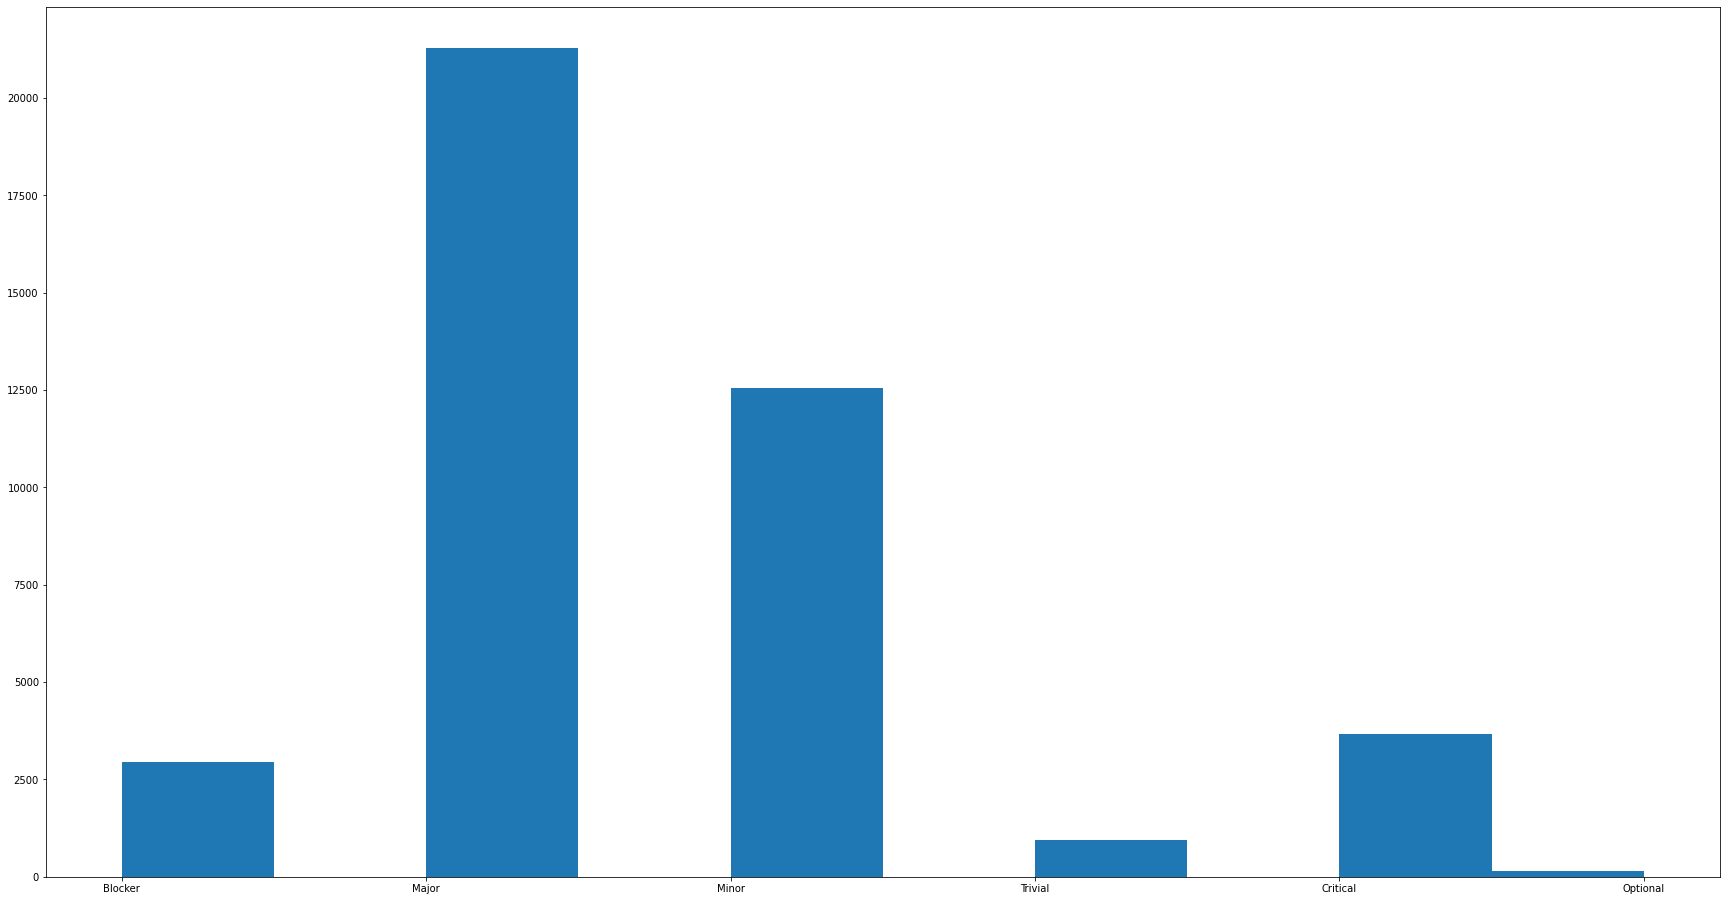

In [28]:
plt.figure(figsize=(30,16))
plt.hist(dataset.priority)

The data is highly biased to Major. However we only have ~ 400+ data points so we are still going to use it as is. 

Ok there are 6 categories. We will use the following labels:


1.   Optional
2.   Trivial
3.   Minor
4.   Major
5.   Critical
6.   Blocker



In [63]:
# mapping dictionary to map the priorities to labels
labels = {"Optional": "__label__1",
          "Trivial": "__label__2",
          "Minor": "__label__3",
          "Major": "__label__4",
          "Critical": "__label__5",
          "Blocker": "__label__6"}

In [64]:
# standard train/test split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(dataset.features, dataset.priority, test_size=0.3)

In [77]:
# write lst file function
def write_lst_data_to_file(path, Xdata, Ydata):
    with open(path, 'wb') as fp:
       num_rows = Xdata.shape[0]
       for i in range(1,num_rows):
            output = labels[Ydata.iloc[i]] + " " + Xdata.iloc[i]
            fp.write(output.encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [75]:
# write file function
def write_data_to_csv(path, Xdata, Ydata):
    with open(path, 'wb') as fp:
       num_rows = Xdata.shape[0]
       for i in range(1,num_rows):
            output = labels[Ydata.iloc[i]] + "," + Xdata.iloc[i]
            fp.write(output.encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [73]:
# write train data file
write_lst_data_to_file("/content/gdrive/My Drive/Colab Notebooks/Octopus2/jira_largeset_train.lst",Xtrain,Ytrain)

In [78]:
# write test data file
write_lst_data_to_file("/content/gdrive/My Drive/Colab Notebooks/Octopus2/jira_largeset_test.lst",Xtest,Ytest)

# Training the Model

## Readers familiar with AWS and Amazon Sagemaker

The steps on how to use BlazingText for text classification can be found here: https://youtu.be/G2tX0YpNHfc and https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html

Guide to setting the algorithm: https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html

This is also very useful in figuring out the parameters: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_text_classification_dbpedia/blazingtext_text_classification_dbpedia.ipynb 

## Newbies to Amazon Sagemaker

Here are the steps:


1.   Create a bucket in S3
2.   Upload the jira_largeset_train.lst and jira_largeset_test.lst to the bucket
3.   On Sagemaker, navigate to "Training Jobs"
4.   Create a new training job
5.   You'll need to sort out the IAM role you will need to be able to access your S3 bucket
6.   Choose the BlazingText Algorithm
7.   Choose a "ml.c5.4xlarge" instance
8.   Follow the hyperparameter settings for "supervised" in https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html
9.   I set epochs to 20 and enabled early stopping
10.  Added the 2 channels:
     *   train: Input mode: File, add the S3 location of the train data set
     *   validation: Input mode: file, add the S3 location of the test data set
11.  I added S3 locations for checkpoint and output as well
12.  Once done, click on "Create Training Job"




# Evaluate Model


Once the training job is completed we can evaluate the model

1.   In the training job, click on the "View algorithm metrics" link under "Monitor"
2.   Select "validation:accuracy" - you will see the value on the graph above 
3.   Select "train:accuracy" - you will see the value on the graph above



In the training I ran, I got a 0.572 validation accuracy and 0.69 training accuracy. This is better than the 1DConv NN that I had created previously 

# Hyperparameter Tuning

The next step was to use the Hyperparameter tuning capability of Sagemaker for BlazingText text classification. I followed the guideline for which parameters to tune using this - https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext-tuning.html

The steps are:

1.   At the Sagemaker service click on "Hyperparameter tuning jobs"
2.   Click on "Create hyperparameter tuning job"
3.   Fill in the name, select Early Stopping and Bayesian tuning strategy. Click on Next
4.   Click on "Add training job definition"
5.   Make sure you have the right IAM role selected
6.   For "Algorithm options" use the same one as you have set in the "Newbies to Amazon Sagemaker" section
7.   For "Objective metric" I used ```valiation:accuracy``` and ```maximize```
8.   For "Hyperparameter configuration" I followed the guidance in https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext-tuning.html . One thing to note is that if there is no variation, you need to set the type to "Static"
9.    Click on "Next"
10.   For the Input Channel, Checkpoint and Output data configuration use the same as in the "Newbies to Amazon Sagemaker" section
11.   Click on "Next"
12.   In the "Resource configuration" I used a ```ml.c5.4xlarge``` with 100Gb
13.   Stopping condition I set to 30mins max for each run (it should be much much less)
14.   Click on "Next" and then "Next" again
15.   For resource limits, that depends on what you have configured as your spend limits. For me I had to set the max parallel training jobs to 8 and max training jobs to 100.
16.   Click on "Next" then click on "Create Hyperparameter tuning job"




The tuning job I set up had 87 that ran to completion 13 that stopped. The best job had validation accuracy of 0.55

# Create Production Endpoint using Lambda and API Gateway 


Creating the model and endpoint:
1.   Once the training job is completed, click on the "Create Model" on the top right hand corner
2.   Important paramters to note:
     - IAM role has to be correct
3.   Click on "Create Model"
4.   Next click on the model you have named and then click on the "Create endpoint" button on the top right hand corner and fill up the form (mostly default params)
5.   Click on "Create endpoint configuration" then click "Create endpoint"

Creating the Lambda:
1.   Navigate to AWS Lambda
2.   Click on "Create Function"
3.   Select "Author from scratch"
4.   Choose "Python 3.6" runtime
5.   You may need to create an execution role for the Lambda
6.   Click on "Create function"
7.   Set environment variable "ENDPOINT_NAME" to the endpoint name
8.   Add the following handler code



In [ ]:
# Do not run this code in the notebook. It is to be pasted into the Lamda
import json
import os
import boto3

ENDPOINT_NAME = os.environ['ENDPOINT_NAME']
sgm_runtime = boto3.client('runtime.sagemaker')

reverse_label_map = {"__label__1": "Optional",
                     "__label__2": "Trivial",
                     "__label__3": "Minor",
                     "__label__4": "Major",
                     "__label__5": "Critical",
                     "__label__6": "Blocker"}
                     
def format_payload(data):
    list = []
    list.append(data)
    payload = {"instances": list}
    return json.dumps(payload)
    
    
def lambda_handler(event, context):
    data = event['body']
    payload = format_payload(data)
    response = sgm_runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                           ContentType='application/json',
                                           Body=payload)
    prediction = json.loads(response['Body'].read().decode())
    prediction_label = prediction[0]['label'][0]
    mapped_prediction = reverse_label_map[prediction_label]
    return {
        'statusCode': 200,
        'body': mapped_prediction}

Creating the API Gateway


1.   Navigate to the AWS API Gateway 
2.   Click on "Create API"
3.   Go to "REST API" (not the private one)
4.   Click on "Build"
5.   Select the following:
     - REST
     - Create New API
     - Give it a name
     - Endpoint type: Regional
6.   Click on Create API
7.   Next, click on the "Actions" button -> Create Resource
8.   Enter a resource name and click on "Create Resource"
9.   Select the resource and then Actions->Create Method
10.  Select "Post" and click on the tick (ie. OK)
11.  Configure it to point to the Lambda function
12.  Save
13.  (You can test out the API endpoint by clicking on the "Test" link)

Next is deploying the API
1.   Select the API and click on Action->Deploy API
2.   Select "[New Stage]" and just put in "production" for the rest of the fields
3.   Under Stages you will find your API gateway. Select that to find your URL



# Test API

In [1]:
! curl -X POST "https://76lqe5sfo7.execute-api.us-east-1.amazonaws.com/production/blazingtext" -d '{"body": "Confusing error messages if the user gets the @Embed('filename') syntax wrong This bug was imported from another system and requires review from a project committer before some of the details can be marked public. For more information about historical bugs, please read: [Why are some bugs missing information?|"}'

{"statusCode": 200, "body": "Minor"}